In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
import cv2
import heapq
import time
import torch

from frechetdist import frdist
from refine_transform import match_fragments, Translation,check_possibility_of_translation, compute_fast_geom_morph_score,nms
from find_transform import estimate_transform_params, transform_line, estimate_mean_squared_transformation_error

from utils import build_fragment, Fragment, rotate_fragment, pad_fragment
from utils import shift_fragment, blend_fragments, transform_fragment

from shape_align import align_two_fragments, pairwise_alignment
from find_transform import find_best_transform_ransac, aligned_coords2line

from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from dataclasses import dataclass
from scipy.ndimage import shift

In [2]:

from extend import extend_image, load_model

Detectron v2 is not installed


In [3]:
%matplotlib inline

# Extending fragments

In [4]:
data_dir = '../voronoi/example'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [66]:
from skimage.io import imread
from utils import preprocess

def build_fragment(mask_index, model, indir='../voronoi/example', ext_step=15, pad=10):
    fragment = imread(indir + '/' + 'fresco.jpg')
    mask = imread(indir + '/' + f'new_mask_{mask_index}.png', as_gray=True) > 0.8
    mask = mask[:,:,None]
    cropped_frag, cropped_inv_mask, pos = preprocess(fragment, mask.astype(bool), ext_step=25)
    cropped_frag = np.pad(cropped_frag, ((pad, pad), (pad, pad), (0, 0)))
    extended = cropped_frag
    
    mask = np.invert(cropped_inv_mask)
    extended_mask = cv2.dilate(mask * 1.0, np.ones((20, 20)))
    extended_mask = np.pad(extended_mask, ((pad, pad), (pad, pad)))
    extended_masked = extended_mask[:, :, None] * extended

    mask = np.pad(mask, ((pad, pad), (pad, pad), (0, 0)))
    mask = cv2.erode(mask * 1.0, np.ones((6, 6), np.uint8))[:,:,None]

    return Fragment(cropped_frag / 255, extended_masked / 255,mask, extended_mask[:,:,None])

In [67]:
frag1 = build_fragment(95, None)
frag2 = build_fragment(103, None)

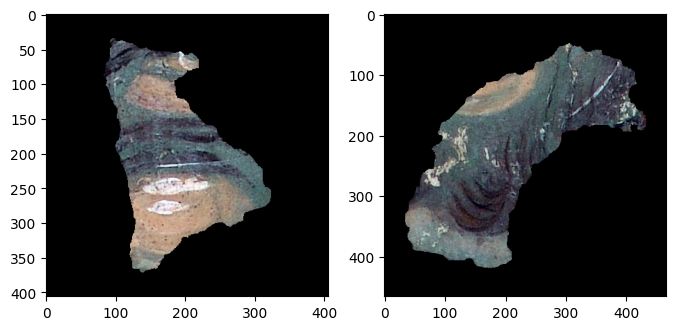

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [69]:
def extend_fragment(frag, model):
    inv_mask = np.invert(frag.mask.astype(bool))
    extended = extend_image(frag.fragment * 255, inv_mask, model) * frag.extended_mask
    return Fragment(
        frag.fragment,
        extended,
        frag.mask,
        frag.extended_mask
    )

In [9]:
model = load_model()

In [70]:
ext_frag1 = extend_fragment(frag1, model)
ext_frag2 = extend_fragment(frag2, model)

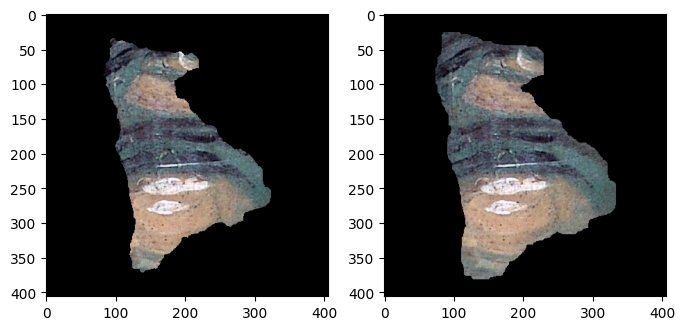

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(ext_frag1.fragment)
axes[1].imshow(ext_frag1.extended_frag)

In [73]:

frag3 = rotate_fragment(pad_fragment(ext_frag1, 200), 60)

# Matching fragments

In [74]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
    line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
    line1 -= frag1.fragment.shape[0] // 2
    line2 -= frag2.fragment.shape[0] // 2
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform, line1, line2

In [126]:
best_transform_params, subcurve1, subcurve2 = find_best_fragment_transform(
    palette, 
    frag3,
    frag2
)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 1788/1788 [00:10<00:00, 176.58it/s]


In [127]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(best_transform_params[0])), best_transform_params[2], best_transform_params[3]

In [128]:
def compute_fast_geom_morph_score(subcurve1, subcurve2, transform_params, max_distance=30):
    """
    subcurve1: (n, 2) array, common subcurve from frag1
    subcurve2: (n, 2) array, common subcurve from frag2
    transform_params: tuple of (theta, shift_x, shift_y)
    """
    theta, shift_x, shift_y = transform_params
    transformed_subcurve = np.zeros(subcurve1.shape)
    theta_rad = np.deg2rad(theta)
    transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y
    transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x
    score = (max_distance - np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1))) / max_distance
#     print(np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1)))
    return score ** (1 / 3) if score > 0 else 0

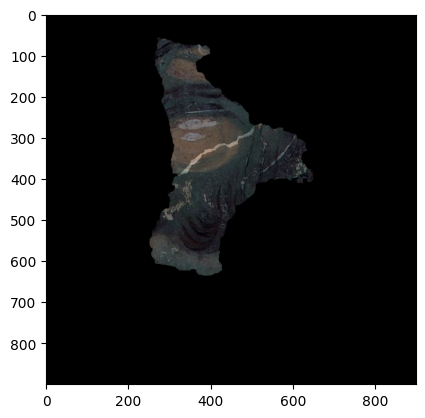

In [129]:
blended = blend_fragments(
    pad_fragment(frag2, 300),
    shift_fragment(
        rotate_fragment(pad_fragment(frag3, 300), theta), 
        int(shift_x),
        int(shift_y)
    )
#     transform_fragment(
#         pad_fragment(frag3, 400),
#         best_transform_params
#     )
)
plt.imshow(blended.fragment)
# print(compute_fast_geom_morph_score(subcurve1, subcurve2, (theta, shift_x, shift_y)))

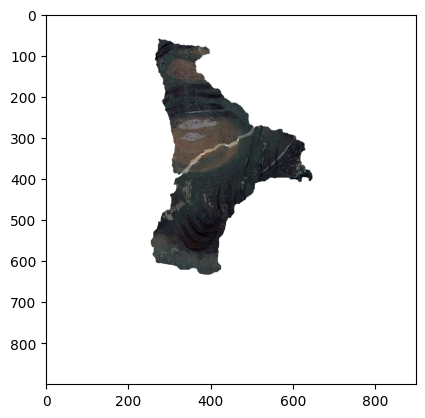

In [130]:
fr = blended.fragment
fr[blended.mask[:,:,0] == 0] = 1
plt.imshow(blended.fragment)

In [79]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(best_transform_params[0])), best_transform_params[2], best_transform_params[3]

In [80]:
def compute_content_score(frag1, frag2):
    img1, img2 = frag1.extended_frag, frag2.extended_frag
#     img1 = (img1 - img1.min()) / (img1.max() - img1.min()) - 0.5
#     img2 = (img2 - img2.min()) / (img2.max() - img2.min())
    where = np.logical_and(frag1.extended_mask, frag2.extended_mask)
    img1 = (img1 - 0.5) * where
    img2 = (img2 - 0.5) * where
#     img1, img2 = img1 / img1.max() - 0.5, img2 / img2.max() - 0.5 
    cov = (img1 * img2).sum()
    corr = cov / np.sqrt((img1 ** 2).sum() * (img2 ** 2).sum())
    return corr

In [81]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
    img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:, pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]
    
    where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    cross_corr = (img_cross_corr + features_cross_corr) / 2
    return cross_corr
    

In [82]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [83]:
def match_fragments(frag1, frag2, initial_params, subcurve1, subcurve2, beta=0.5):
    """
    initial_params: (angle, x, y)
    frag1, frag2: Fragments
    subcurve1, subcurve2: common subcurves from frag1 and frag2
    """
    theta, x_initial, y_initial = initial_params
    print(theta, x_initial, y_initial)
#     size = max(max(frag1.mask.shape[0], frag1.mask.shape[1]), max(frag2.mask.shape[0], frag2.mask.shape[1]))
    size = 200
    padded_frag1 = pad_fragment(frag1, size)
    padded_frag2 = pad_fragment(frag2, size)
    
    tensor1 = torch.tensor(padded_frag1.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
    features1 = feature_extractor(tensor1)
    features1 = features1.squeeze(0).detach().numpy()
    
    resized_mask1 = skimage.transform.resize(
        padded_frag1.extended_mask,
        (padded_frag1.fragment.shape[0] // 2, padded_frag1.fragment.shape[1] // 2)
    )
    
    
    global_res = []
    shifts = [(x, y) for x in range(x_initial - 15, x_initial + 15, 3) for y in range(y_initial - 15, y_initial + 15, 3)]
    for phi in np.arange(theta - 8, theta + 8, 2):
        rot_frag2 = rotate_fragment(padded_frag2, phi)
        tensor2 = torch.tensor(rot_frag2.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
        features2 = feature_extractor(tensor2)
        features2 = features2.squeeze(0).detach().numpy()
        resized_mask2 = skimage.transform.resize(
            rot_frag2.extended_mask, 
            (rot_frag2.fragment.shape[0] // 2, rot_frag2.fragment.shape[1] // 2)
        )
        
        # compute geom score
        for (x, y) in tqdm(shifts):
            transformed2 = shift_fragment(rot_frag2, x, y)
            if check_possibility_of_translation(padded_frag1, transformed2):
                geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                prob = geom_score
                print(prob)
                # prob = estimate_probability_of_neighbourhood(frag1, transformed2)
                if prob > 0.5:
                    # compute content score
#                 prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
#                     content_score = compute_content_score(padded_frag1, transformed2)
                    content_score = compute_new_content_score(
                        padded_frag1, transformed2,
                        features1, features2,
                        resized_mask1, resized_mask2,
                        (x, y)                        
                    )
                    prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                    
#                     prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                    print(geom_score, content_score, prob)
                    trans = Translation(x, y, phi, prob)
#                     heapq.heappush(global_res, trans)
                    global_res.append(trans)
#         global_res.extend(res)
    filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
    return filtered_res

In [84]:
start_time = time.time()
res = match_fragments(
    pad_fragment(frag2, 200),
    pad_fragment(frag3, 200),
    (theta, int(shift_x), int(shift_y)),
    subcurve1,
    subcurve2
)
print("--- %s seconds ---" % (time.time() - start_time))

-59.750716725437165 -64 -227


 30%|████████████████████████▎                                                        | 30/100 [00:00<00:00, 148.54it/s]

0
0
0
0


 45%|████████████████████████████████████▍                                            | 45/100 [00:00<00:00, 142.74it/s]

0
0
0


 30%|████████████████████████▎                                                        | 30/100 [00:00<00:00, 147.85it/s]

0
0
0
0
0
0
0.14866472931770514
0.4079606335722218
0.4209062676034174
0.5248120341719017


 45%|████████████████████████████████████▉                                             | 45/100 [00:00<00:01, 53.05it/s]

0.5248120341719017 0.4764256546294947 0.49153165818993433
0.5193881254820275


 55%|█████████████████████████████████████████████                                     | 55/100 [00:00<00:00, 50.20it/s]

0.5193881254820275 0.4812750811807162 0.4933423437147231
0.5833449058628437


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [00:01<00:00, 63.81it/s]

0.5833449058628437 0.46511156054326 0.4988115541113364


 14%|███████████▎                                                                     | 14/100 [00:00<00:00, 138.67it/s]

0
0
0.26018702036816904
0.19414045237615046
0.39604582301319863
0.43708566291759915
0.5272420470001951


 28%|██████████████████████▉                                                           | 28/100 [00:00<00:01, 46.02it/s]

0.5272420470001951 0.47807893249502054 0.4934152344248092
0.5365176957044716


 36%|█████████████████████████████▌                                                    | 36/100 [00:00<00:01, 33.89it/s]

0.5365176957044716 0.47856484763086243 0.4964394233174995
0.6080160655547902
0.6080160655547902 0.456435579509077 0.49780362897949104
0.6027509061718489
0.6027509061718489 0.46167181361645127 0.5007392745630596
0.6662477716851316


 46%|█████████████████████████████████████▋                                            | 46/100 [00:01<00:02, 25.50it/s]

0.6662477716851316 0.44720493523522753 0.5022462405930119
0.7152943322490127
0.7152943322490127 0.4390003862388063 0.5038772900515031


 51%|█████████████████████████████████████████▊                                        | 51/100 [00:01<00:01, 25.70it/s]

0.6506388081480968
0.6506388081480968 0.44992437568714727 0.501492564925052
0.7106614518772856


 54%|████████████████████████████████████████████▎                                     | 54/100 [00:01<00:01, 23.34it/s]

0.7106614518772856 0.4397732719867416 0.5037836024391944
0.6852457575453398


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [00:02<00:00, 43.76it/s]

0.6852457575453398 0.4429164217231051 0.5021042305564037


  3%|██▍                                                                                | 3/100 [00:00<00:05, 17.10it/s]

0.36047183738198985
0.46737316377284005
0.5303115094175231
0.5303115094175231 0.45181986731060575 0.47526808055991165


 11%|█████████                                                                         | 11/100 [00:00<00:02, 29.68it/s]

0.5008912021402726
0.5008912021402726 0.4733581772992615 0.4821932555399526
0.571089309023985


 14%|███████████▍                                                                      | 14/100 [00:00<00:04, 17.37it/s]

0.571089309023985 0.4502397363199008 0.48440869675634257
0.6201376485069912
0.6201376485069912 0.4398660276530075 0.4870616775661643


 21%|█████████████████▏                                                                | 21/100 [00:00<00:03, 22.95it/s]

0.5845642383891329
0.5845642383891329 0.44646981888040543 0.4846321458846685
0.6434734149766679


 24%|███████████████████▋                                                              | 24/100 [00:01<00:04, 16.35it/s]

0.6434734149766679 0.43842224381396827 0.49052645497937447
0.6874213505407576
0.6874213505407576 0.437304527171939 0.49766232673465244


 31%|█████████████████████████▍                                                        | 31/100 [00:01<00:03, 20.37it/s]

0.6444523562114298
0.6444523562114298 0.4396668193774436 0.49175457159243424
0.6987532811519777
0.6987532811519777 0.43683282226167147 0.49920702314719534
0.7410121755855481
0.7410121755855481 0.43514034404945456 0.5045643086892484
0.7730298186958715


 41%|█████████████████████████████████▌                                                | 41/100 [00:02<00:03, 18.19it/s]

0.7730298186958715 0.4289330899540709 0.5036647439286454
0.6884264276448906
0.6884264276448906 0.43663311314434655 0.49725740287857373
0.7419258389366118
0.7419258389366118 0.4372520931370044 0.506597245171512
0.7843758421906508


 44%|████████████████████████████████████                                              | 44/100 [00:02<00:04, 13.16it/s]

0.7843758421906508 0.43462917058802814 0.5105059592762671
0.8176996156942182
0.8176996156942182 0.4272810536721119 0.5081556592821904


 51%|█████████████████████████████████████████▊                                        | 51/100 [00:02<00:02, 17.56it/s]

0.7094499534119562
0.7094499534119562 0.4362628256706029 0.500505916693148
0.7684011225530906


 54%|████████████████████████████████████████████▎                                     | 54/100 [00:03<00:03, 14.83it/s]

0.7684011225530906 0.4365256034128884 0.5099407540475713
0.8186823735218285
0.8186823735218285 0.4349948375060504 0.515532065999891


 61%|██████████████████████████████████████████████████                                | 61/100 [00:03<00:02, 19.20it/s]

0.720021562468017
0.720021562468017 0.43248280989197196 0.49889340819342765
0.779070697215539


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [00:03<00:00, 39.53it/s]

0.779070697215539 0.43282148752072175 0.5080936582635881


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

0.5449690083062017


  2%|█▋                                                                                 | 2/100 [00:00<00:20,  4.70it/s]

0.5449690083062017 0.4502095345266857 0.4779092302803277
0.6069587879586436
0.6069587879586436 0.4344488048457037 0.47991609710671074
0.6516720407062282


  4%|███▎                                                                               | 4/100 [00:00<00:17,  5.48it/s]

0.6516720407062282 0.42957182040860203 0.484628153982633
0.6834718827439153
0.6834718827439153 0.4255550651819004 0.4867867972372585


 11%|█████████                                                                         | 11/100 [00:01<00:05, 15.88it/s]

0.6168032525454805
0.6168032525454805 0.43199556208928513 0.4799278405669433
0.6715328721946183
0.6715328721946183 0.42987436179368366 0.4884678797407
0.7130547458731946


 15%|████████████▎                                                                     | 15/100 [00:01<00:08, 10.37it/s]

0.7130547458731946 0.4271034825477238 0.49300566545886454
0.7436430478873528
0.7436430478873528 0.42748307521322965 0.49806758191297557


 21%|█████████████████▏                                                                | 21/100 [00:01<00:05, 15.78it/s]

0.6699665302704454
0.6699665302704454 0.4287099036941616 0.4871892617311471
0.7218072578790201


 23%|██████████████████▊                                                               | 23/100 [00:02<00:06, 11.93it/s]

0.7218072578790201 0.4298284131897726 0.49681780558522054
0.7626532112343711
0.7626532112343711 0.43207456037105246 0.5050468772025963
0.7937581135900682


 25%|████████████████████▌                                                             | 25/100 [00:02<00:06, 11.69it/s]

0.7937581135900682 0.427832632928637 0.5055139043679686
0.7024941006233767


 31%|█████████████████████████▍                                                        | 31/100 [00:02<00:04, 16.09it/s]

0.7024941006233767 0.42911982436290247 0.4930802453284214
0.7605428023802218
0.7605428023802218 0.4320811653244825 0.5047437198370498
0.8028344632631443


 35%|████████████████████████████▋                                                     | 35/100 [00:03<00:05, 12.25it/s]

0.8028344632631443 0.4331322533579932 0.51167348279594
0.8358185196647145
0.8358185196647145 0.4289167990952731 0.5120029739604169


 41%|█████████████████████████████████▌                                                | 41/100 [00:03<00:03, 17.26it/s]

0.7198479775586496
0.7198479775586496 0.431699989154971 0.49817094836038256
0.7779770480369382


 43%|███████████████████████████████████▎                                              | 43/100 [00:03<00:04, 12.89it/s]

0.7779770480369382 0.43375104260815045 0.5087915025460872
0.828039689192755
0.828039689192755 0.4354252403175943 0.5171626838904569
0.8701466374728641


 45%|████████████████████████████████████▉                                             | 45/100 [00:03<00:04, 12.58it/s]

0.8701466374728641 0.4265103999594093 0.5138350945266894
0.7268763796908692
0.7268763796908692 0.42978547315894594 0.4975756319298722


 51%|█████████████████████████████████████████▊                                        | 51/100 [00:03<00:02, 17.45it/s]

0.785137228517489


 53%|███████████████████████████████████████████▍                                      | 53/100 [00:04<00:04, 10.86it/s]

0.785137228517489 0.43264025768309144 0.5087814828554121
0.8358249212773183
0.8358249212773183 0.4311295770057401 0.5141036307600207


 61%|██████████████████████████████████████████████████                                | 61/100 [00:04<00:02, 17.10it/s]

0.7236558032475662
0.7236558032475662 0.42690927898174674 0.49450208284831276


  1%|▊                                                                                  | 1/100 [00:00<00:16,  6.13it/s]

0.6429566515555156
0.6429566515555156 0.42685338605481127 0.48071034812674573
0.6952594621175601


  3%|██▍                                                                                | 3/100 [00:00<00:15,  6.09it/s]

0.6952594621175601 0.4200307154852787 0.4838812307287747
0.7354197498216553
0.7354197498216553 0.4263159606806279 0.49577567633048747
0.7652117195282927


  5%|████▏                                                                              | 5/100 [00:00<00:15,  6.04it/s]

0.7652117195282927 0.4267718720379634 0.5005696205135183
0.7849905227131247
0.7849905227131247 0.4249594433175785 0.5016527622111653


 11%|█████████                                                                         | 11/100 [00:01<00:05, 15.41it/s]

0.6736861008977337
0.6736861008977337 0.4177440984087167 0.47831702556503375
0.7361135995624188


 13%|██████████▋                                                                       | 13/100 [00:01<00:07, 11.00it/s]

0.7361135995624188 0.42589245390500735 0.49549862692279467
0.7814346440083918
0.7814346440083918 0.4277764868451609 0.5037752636872701
0.8123272030941121


 15%|████████████▎                                                                     | 15/100 [00:01<00:09,  9.07it/s]

0.8123272030941121 0.4257190866441922 0.5059905370895105
0.8335092885529397
0.8335092885529397 0.4236765992462864 0.5067286491239558
0.6931268095204326


 21%|█████████████████▏                                                                | 21/100 [00:01<00:05, 14.59it/s]

0.6931268095204326 0.42149129579892863 0.4848254552390236
0.7551064817741212
0.7551064817741212 0.4297029738399479 0.501781795588029
0.8077805973054548


 25%|████████████████████▌                                                             | 25/100 [00:02<00:06, 11.47it/s]

0.8077805973054548 0.429336326917483 0.5087925692380754
0.8517987578998332
0.8517987578998332 0.4263362699937057 0.5114985841116421


 31%|█████████████████████████▍                                                        | 31/100 [00:02<00:04, 16.35it/s]

0.7019843987742738
0.7019843987742738 0.4238378440079696 0.4883353862589396
0.7638906384910127


 33%|███████████████████████████                                                       | 33/100 [00:02<00:05, 12.35it/s]

0.7638906384910127 0.4322054939168336 0.5053468762282131
0.8170821813895127
0.8170821813895127 0.4288994067296873 0.5096004321729921


 41%|█████████████████████████████████▌                                                | 41/100 [00:03<00:03, 19.06it/s]

0.7004746554944635
0.7004746554944635 0.42795967783502353 0.491727433779701
0.7623873214228201


 44%|████████████████████████████████████                                              | 44/100 [00:03<00:03, 18.43it/s]

0.7623873214228201 0.43024881466009296 0.5033436914959724
0.6885654232714308


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [00:03<00:00, 38.82it/s]

0.6885654232714308 0.4241881002967306 0.48644565584564237


  1%|▊                                                                                  | 1/100 [00:00<00:15,  6.26it/s]

0.589638700800895
0.589638700800895 0.42771493652176423 0.47081234956909923
0.6678079278341704


  3%|██▍                                                                                | 3/100 [00:00<00:19,  4.90it/s]

0.6678079278341704 0.42736445284690144 0.4856504096623139
0.7295957526987156
0.7295957526987156 0.424637612494094 0.49337882438918823
0.7805067029759564


 11%|█████████                                                                         | 11/100 [00:00<00:05, 16.60it/s]

0.7805067029759564 0.42159303621152083 0.49791453869988755
0.6164084237299998
0.6164084237299998 0.43162182268258803 0.4795406381860583


 13%|██████████▋                                                                       | 13/100 [00:01<00:05, 14.83it/s]

0.6917880066727231
0.6917880066727231 0.42613600712384386 0.48868954110704016


 21%|█████████████████▏                                                                | 21/100 [00:01<00:03, 23.10it/s]

0.630885872099442
0.630885872099442 0.43214809755143996 0.4828495233602209
0.7050498009314161


 31%|█████████████████████████▍                                                        | 31/100 [00:01<00:02, 30.49it/s]

0.7050498009314161 0.4250193563357163 0.4898752932136741


 33%|██████████████████████████▋                                                      | 33/100 [00:00<00:00, 159.44it/s]

0.47731509899329333


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 132.89it/s]

--- 22.22362494468689 seconds ---


In [85]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

In [86]:
padded_frag2 = pad_fragment(frag2, 200)

In [119]:
def visualize_transform(frag, anchor_frag, t, end_transform, start_transform = Translation(-200, 100, 60, -1)):
    alpha = t / 80
    if alpha < 0:
        alpha = 0
    if alpha > 1:
        alpha = 1
    transform = Translation(
        int((1 - alpha) * start_transform.x + alpha * end_transform.x),
        int((1 - alpha) * start_transform.y + alpha * end_transform.y),
        (1 - alpha) * start_transform.angle + alpha * end_transform.angle,
        -1
    )
    transformed = shift_fragment(rotate_fragment(frag, transform.angle), transform.x, transform.y)
#     transformed.fragment *= transformed.mask
    anchor = Fragment(
        anchor_frag.fragment, # * anchor_frag.mask,
        anchor_frag.mask,
        anchor_frag.extended_frag, 
        anchor_frag.extended_mask
    )
    blended = blend_fragments(anchor, transformed)
    return blended.fragment

In [108]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]

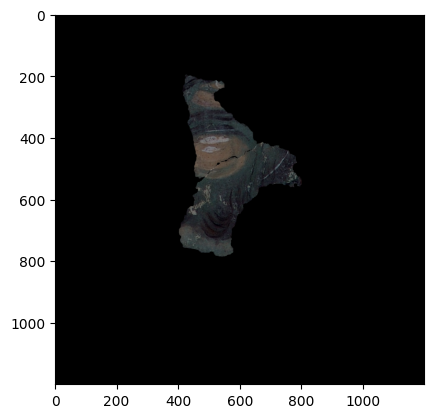

In [110]:
plt.imshow(visualize_transform(pad_fragment(frag3, 400), pad_fragment(frag2, 400), 45, tr, start_transform = Translation(-400, 200, 60, -1)))

In [120]:
def create_video_from_images(anchor_frag, tr_frag):
    video_filename = 'output/blended_video.mp4'

    first_image = visualize_transform(
        pad_fragment(tr_frag, 400), 
        pad_fragment(anchor_frag, 400),  0, tr,
        start_transform = Translation(-400, 200, 60, -1)
    ).astype(np.uint8)
    first_image = cv2.cvtColor(first_image, cv2.COLOR_RGB2BGR)
    h, w, _ = first_image.shape

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    vid_writer = cv2.VideoWriter(video_filename, codec, 30, (w, h))

    for t in range(-40,160):
#         loaded_img = cv2.imread(os.path.join(folder, img))
        loaded_img = (255 * visualize_transform(
            pad_fragment(tr_frag, 400), 
            pad_fragment(anchor_frag, 400), 
            t, 
            tr,
            start_transform = Translation(-400, 200, 60, -1)
        )).astype(np.uint8)
        loaded_img = cv2.cvtColor(loaded_img, cv2.COLOR_RGB2BGR)
        for _ in range(1):
            vid_writer.write(loaded_img)

    vid_writer.release()

In [121]:

create_video_from_images(frag2, frag3)

0.5171626838904569
0.017589605886958577


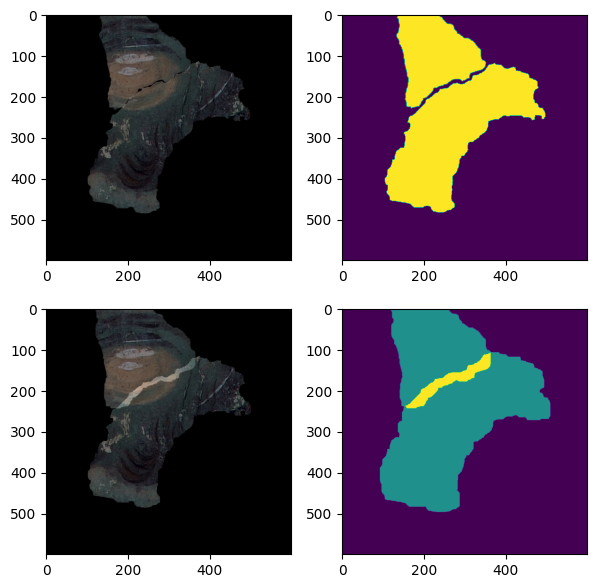

In [113]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
# corr = compute_geom_morph_score(padded_frag0, shift_fragment(padded_frag1, y, x))
print(tr.confidence)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(frag3, tr.angle), x, y)
print(compute_content_score(padded_frag2, transformed))
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

In [124]:
skimage.io.imsave('output/frag93.jpg', build_fragment(93, None).fragment)
skimage.io.imsave('output/frag89.jpg', build_fragment(89, None).fragment)
skimage.io.imsave('output/frag94.jpg', build_fragment(94, None).fragment)

# Constructing new content score

In [23]:
import torch

In [24]:
from torch.hub import load

In [25]:
# resnet = load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# resnet

In [26]:

mobilenet = load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [27]:
mobilenet.features[0]

ConvNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

In [28]:
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

In [29]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

# axes[0].imshow(features[0][11].detach().numpy())
# # plt.show()
# axes[1].imshow(frag1.fragment)
# plt.show()

In [30]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
    img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:, pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]
    
    where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    cross_corr = (img_cross_corr + features_cross_corr) / 2
    return cross_corr
    

In [31]:
resized_mask1 = skimage.transform.resize(
    padded_frag2.extended_mask,
    (padded_frag2.fragment.shape[0] // 2, padded_frag2.fragment.shape[1] // 2)
)
resized_mask2 = skimage.transform.resize(
    transformed.extended_mask, 
    (transformed.fragment.shape[0] // 2, transformed.fragment.shape[1] // 2)
)


In [77]:
tensor1 = torch.Tensor(padded_frag2.extended_frag)
tensor1 = tensor1.permute(2, 0, 1)
tensor1 = tensor1.unsqueeze(0)
features1 = feature_extractor(tensor1)



In [78]:
rotated = rotate_fragment(frag3, tr.angle)

In [79]:
tensor2 = torch.Tensor(rotated.extended_frag)
tensor2 = tensor2.permute(2, 0, 1)
tensor2 = tensor2.unsqueeze(0)
features2 = feature_extractor(tensor2)

0.313030275370951
0.2444888381005605


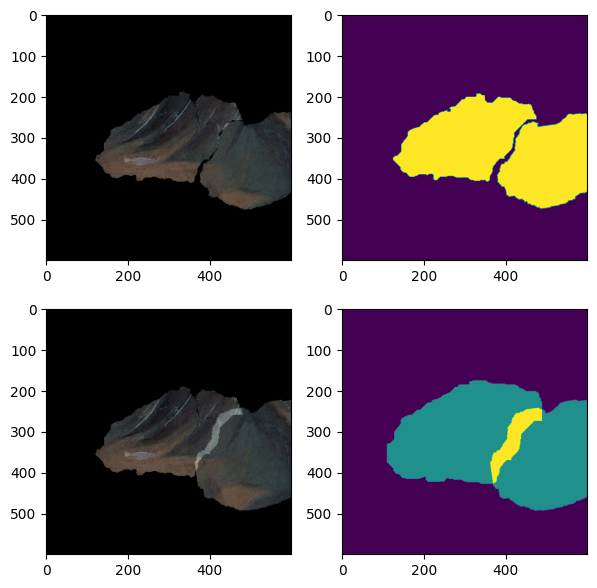

In [33]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
# corr = compute_geom_morph_score(padded_frag0, shift_fragment(padded_frag1, y, x))
print(tr.confidence)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(frag3, tr.angle), x, y)
print(compute_content_score(padded_frag2, transformed))
# print(
#     compute_new_content_score(
#         padded_frag2, 
#         transformed, 
#         features1.detach().numpy()[0], 
#         features2.detach().numpy()[0], 
#         resized_mask1, resized_mask2, 
#         (x, y)
#     )
# )
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

In [59]:

pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
pad

400

In [80]:
features1 = features1.detach().numpy()[0]
features2 = features2.detach().numpy()[0]

In [81]:
features1.shape

(32, 300, 300)

In [82]:

padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
padded_features1.shape

(32, 1100, 1100)

In [92]:
shift = (x, y)
shifted_features2 = padded_features2[
    :,
    pad - shift[1] // 2: -pad - shift[1] // 2, 
    pad - shift[0] // 2: -pad - shift[0] // 2
]

In [84]:

where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)

In [85]:
padded_features1.shape

(32, 1100, 1100)

In [102]:

features1_masked = features1 * where
features2_masked = shifted_features2 * where

In [103]:
features1_masked.shape

(32, 300, 300)

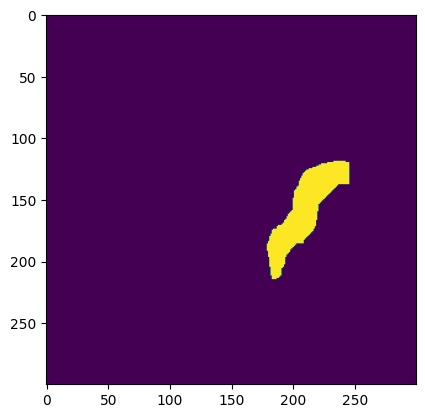

In [104]:
plt.imshow(where[0])

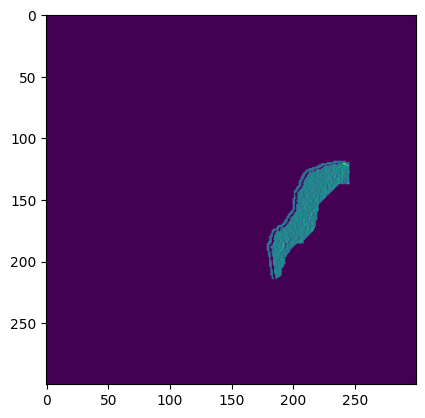

In [106]:
plt.imshow(features2_masked[6])

In [107]:

features_cov = (features1_masked * features2_masked).sum()
features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())

In [108]:
features_cross_corr

0.76188785